# Sentiment of text messages in dialogues

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

![](https://s.yimg.com/ny/api/res/1.2/2lIXqj9S0e.LWR.XNk2CyQ--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTQyNw--/https://s.yimg.com/os/creatr-uploaded-images/2022-03/f0b17610-a3db-11ec-bef2-b9f91328061d)

## About the dataset
This dataset contains people's opinions about a company or a computer game, i.e.
people on twitter express their opinion about a product.
The dataset consists of 4 features:

- Tweet_ID - message ID
- entity - to whom the message is addressed
- tweet content - the message itself
- sentiment - emotional coloring

There are 4 types of emotional coloring in the dataset:
-positive
- Negative
- Neutral
- Irrelevant

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

from keras.layers import Layer
from keras.utils import plot_model
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adam

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Attention
from keras.layers import Concatenate, Dense, Input
from keras.models import Sequential
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from keras.layers import GlobalMaxPooling1D

from bs4 import BeautifulSoup
import re
import spacy
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
df = pd.read_csv('/content/twitter_training.csv',
usecols=[0,1,2,3], names=['Tweet_ID','entity', 'sentiment', 'tweet_content'])


df = df[['Tweet_ID', 'entity', 'tweet_content', 'sentiment']]
df

,Tweet_ID,entity,tweet_content,sentiment
0,2401,Borderlands,im getting on borderlands and i will murder yo...,Positive
1,2401,Borderlands,I am coming to the borders and I will kill you...,Positive
2,2401,Borderlands,im getting on borderlands and i will kill you ...,Positive
3,2401,Borderlands,im coming on borderlands and i will murder you...,Positive
4,2401,Borderlands,im getting on borderlands 2 and i will murder ...,Positive
...,...,...,...,...
60950,4847,GrandTheftAuto(GTA),Whoever vandalizing the speed cameras around t...,Irrelevant
60951,4847,GrandTheftAuto(GTA),Whoever is vandalizing the speed cameras aroun...,Irrelevant
60952,4847,GrandTheftAuto(GTA),OH Whoever is vandalizing the video speed came...,Irrelevant
60953,4847,GrandTheftAuto(GTA),Whoever is mounting the speed cameras around f...,Irrelevant


In [ ]:
df.isnull().mean() * 100

Tweet_ID         0.000000
entity           0.000000
tweet_content    0.918561
sentiment        0.000000
dtype: float64

In [ ]:
df.dropna(inplace=True)
df.shape

(73996, 4)

## Let's see what companies or computer games are in the dataset

In [ ]:
len_entity = df['entity'].unique()
print(len_entity)
print()
print(f'Total No. = {len(len_entity)}')

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']

Общее кол-во = 32


In [ ]:
df['entity'].value_counts()

MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283
Borderlands                       

## After applying value_counts to the entity attribute, we see that approximately the same number of messages were addressed to each organization

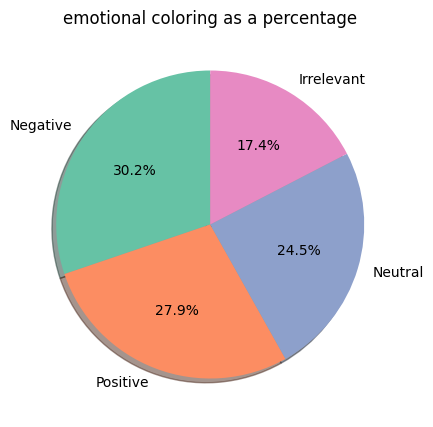

In [ ]:
sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(sentiment,
        labels = sentiment.index,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90,
        colors=sns.color_palette('Set2'))
plt.title("emotional coloring as a percentage")
plt.show()

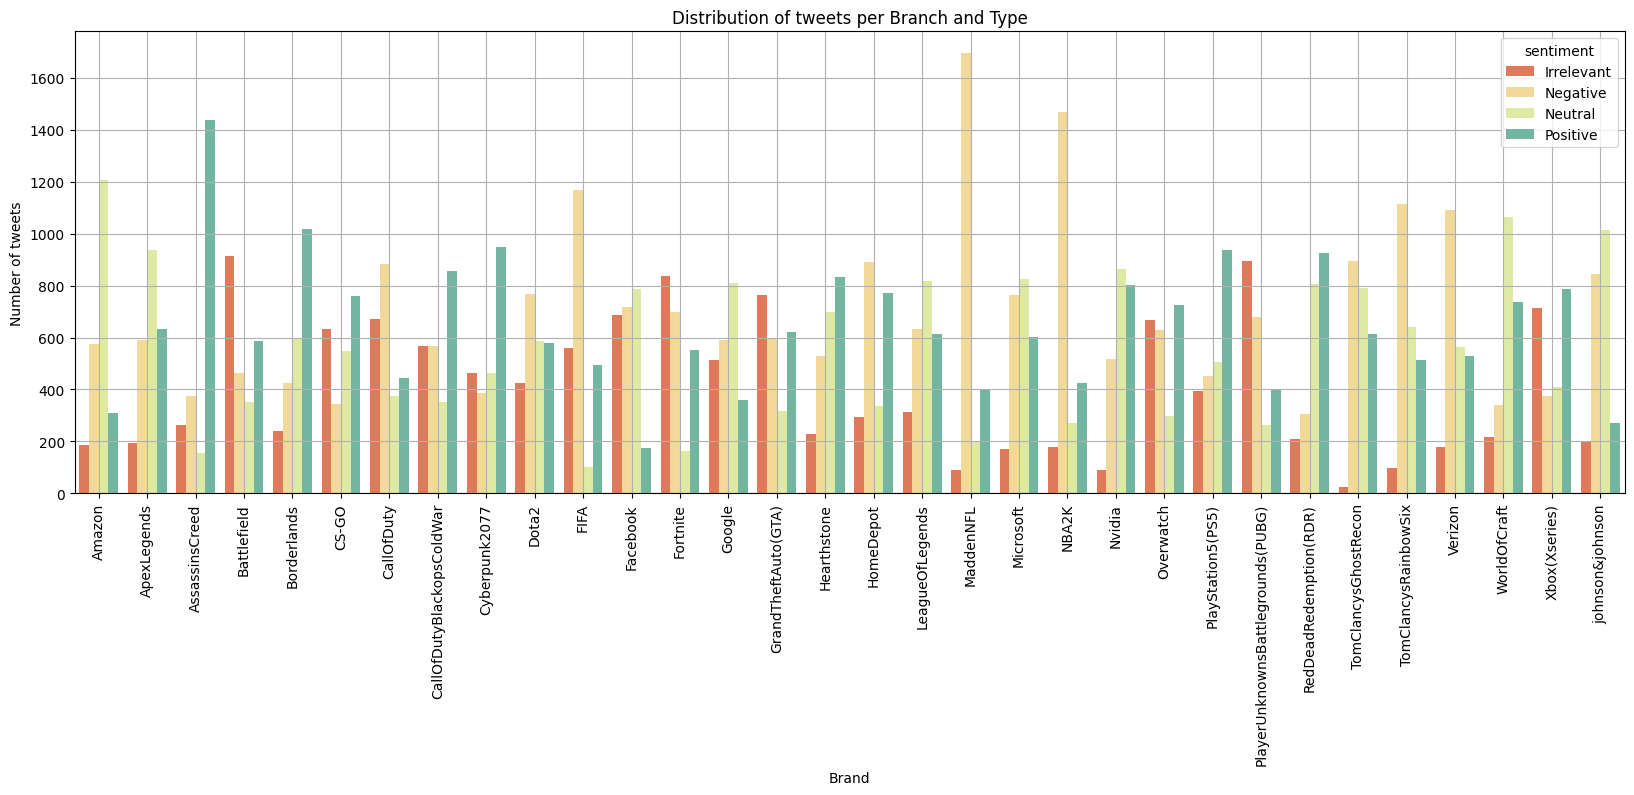

In [ ]:
data1 = df.groupby(by=["entity", "sentiment"]).count().reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(data=data1,x="entity", y="Tweet_ID", hue='sentiment', palette="Spectral")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")
plt.show()

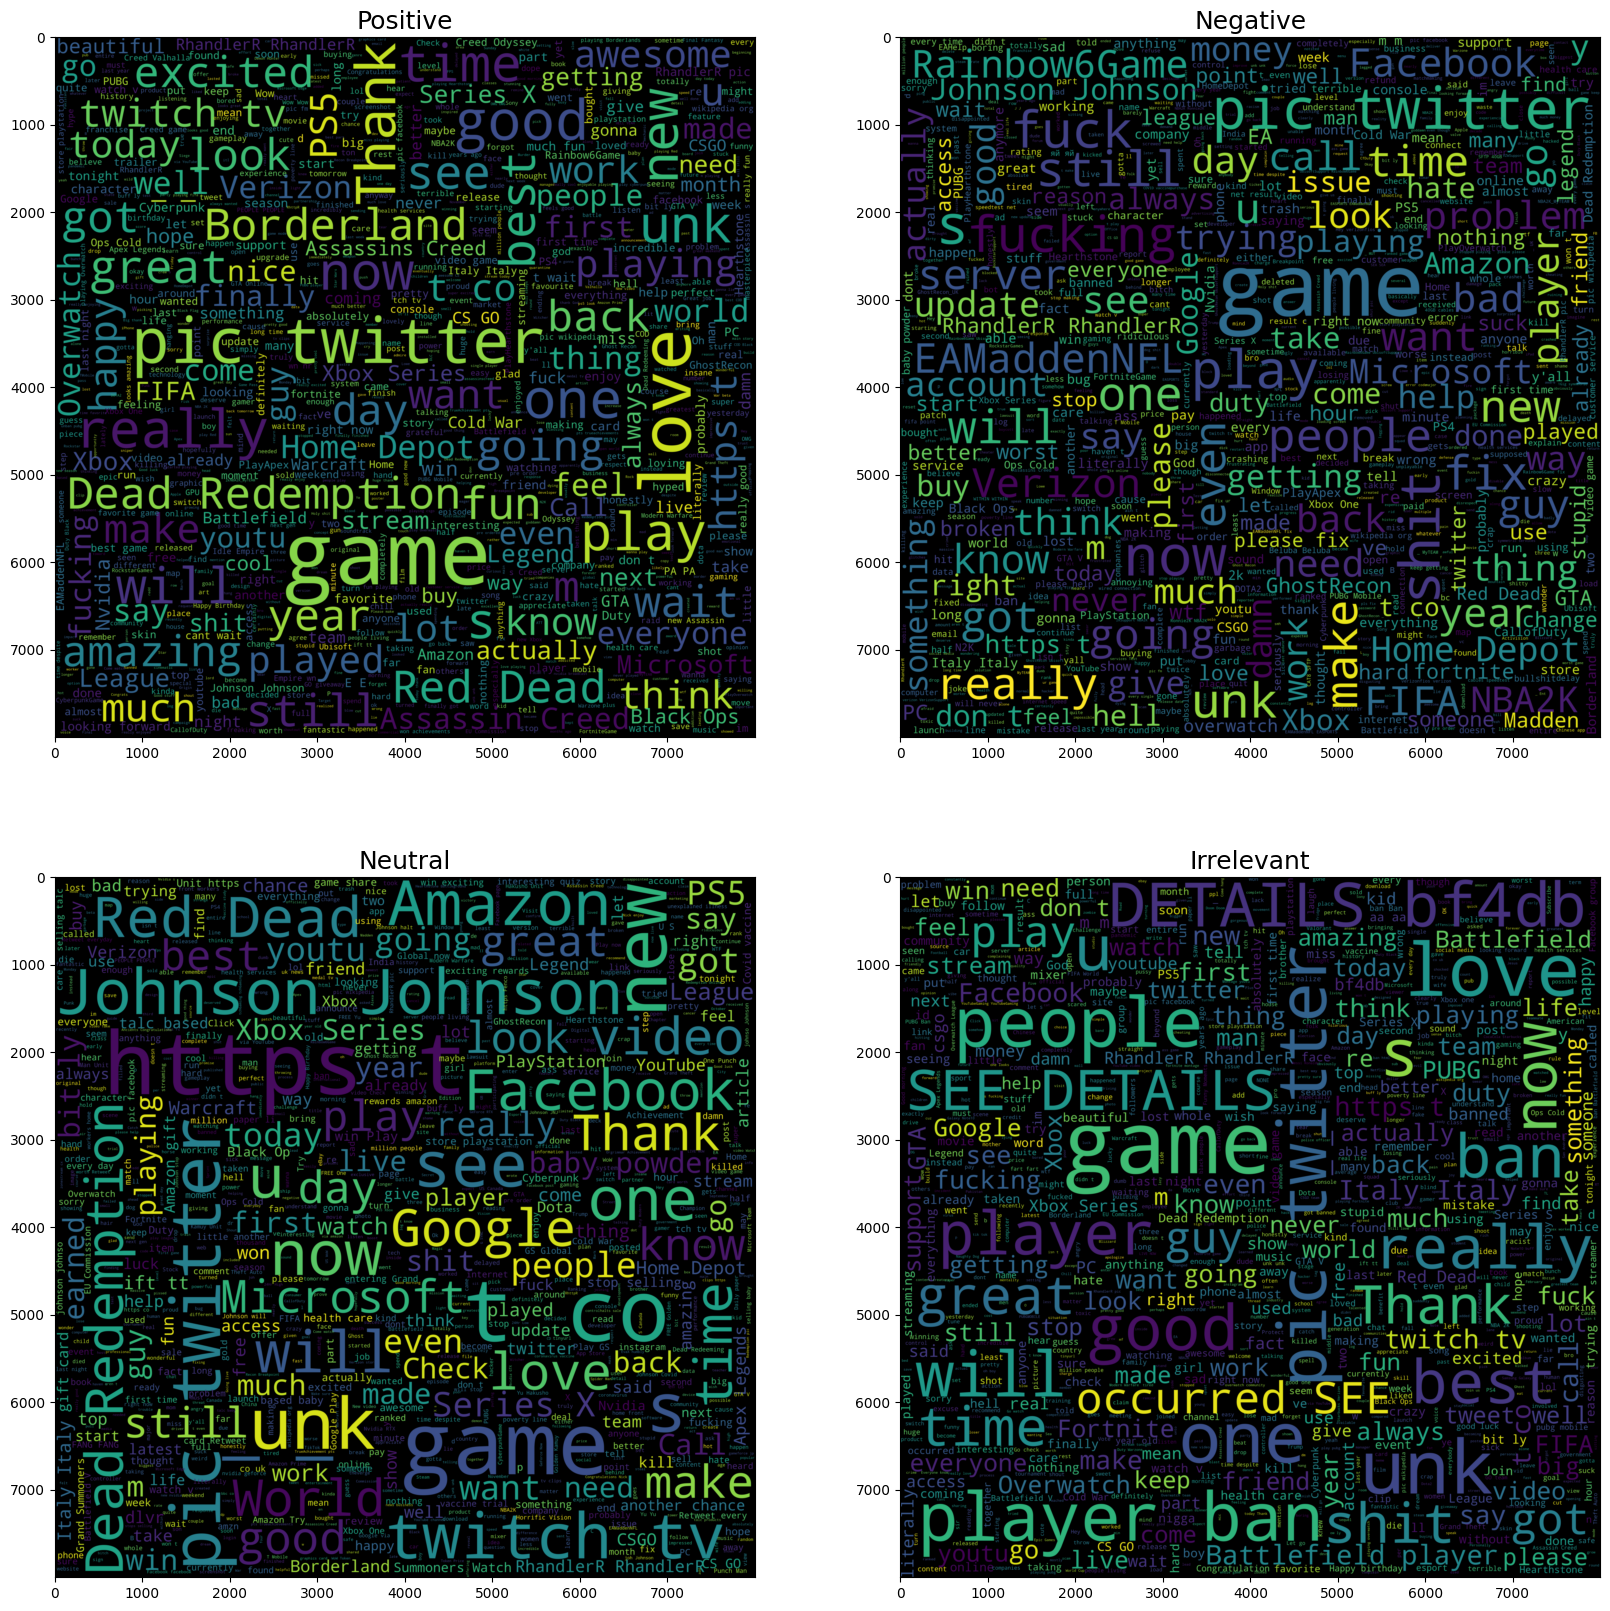

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
word_cloud_text = ''.join(df[df["sentiment"]=="Positive"].tweet_content)
wordcloud = WordCloud(max_font_size=100,max_words=1000,background_color="black",scale=10,width=800,height=800).generate(word_cloud_text)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.set_title('Positive', fontsize=18)
word_cloud_text = ''.join(df[df["sentiment"]=="Negative"].tweet_content)
wordcloud = WordCloud(max_font_size=100,max_words=1000,background_color="black",scale=10,width=800,height=800).generate(word_cloud_text)
ax2.imshow(wordcloud, interpolation="bilinear")
ax2.set_title('Negative', fontsize=18)
word_cloud_text = ''.join(df[df["sentiment"]=="Neutral"].tweet_content)
wordcloud = WordCloud(max_font_size=100,max_words=1000,background_color="black",scale=10,width=800,height=800).generate(word_cloud_text)
ax3.imshow(wordcloud, interpolation="bilinear")
ax3.set_title('Neutral', fontsize=18)
word_cloud_text = ''.join(df[df["sentiment"]=="Irrelevant"].tweet_content)
wordcloud = WordCloud(max_font_size=100,max_words=1000,background_color="black",scale=10,width=800,height=800).generate(word_cloud_text)
ax4.imshow(wordcloud, interpolation="bilinear")
ax4.set_title('Irrelevant', fontsize=18)
plt.show()

<AxesSubplot: xlabel='text_len'>

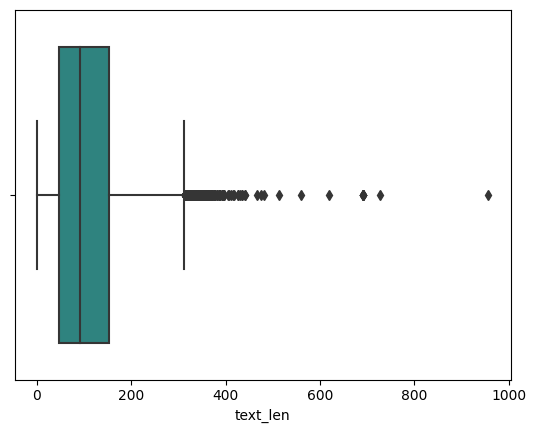

In [ ]:
df_text = df.copy()
df_text.drop(['Tweet_ID', 'sentiment', 'entity'], axis=1, inplace=True)
df_text['tweet_content'] = df_text['tweet_content'].astype('str')
df_text['text_len'] = df_text['tweet_content'].apply(lambda x: len(x))
sns.boxplot(data=df_text, x='text_len', palette='viridis')


### Message lengths in the training set have a standard distribution from 0 to about 350 characters. The first and third quartiles range from approximately 50 to 150 characters, with a median of 100 characters. Also note that there are outliers in the data starting from 350 characters.

# Building a LogisticRegression

## Train the Base Line MOdel

In [ ]:
def change_sentiment(x):
    if x == 'Positive':
        return 1
    elif x == 'Negative':
        return 0
    elif x == 'Neutral':
        return 2
    else:
        return 3

df['sentiment'] = df['sentiment'].transform(lambda x: change_sentiment(x))


In [ ]:
X = df.drop('sentiment', axis=1)
y = df['sentiment']

X = df.drop('sentiment', axis=1)
X.tweet_content
X_train, X_test, y_train, y_test = train_test_split(X.tweet_content, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipe = Pipeline(steps=[('cvect', CountVectorizer()),
                       ('abs', MaxAbsScaler()),
                       ('logreg', LogisticRegression())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('cvect', CountVectorizer()), ('abs', MaxAbsScaler()),
                ('logreg', LogisticRegression())])

In [ ]:
y_pred_test = pipe.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4472
           1       0.79      0.90      0.84      4131
           2       0.89      0.80      0.85      3622
           3       0.91      0.78      0.84      2575

    accuracy                           0.85     14800
   macro avg       0.86      0.84      0.85     14800
weighted avg       0.86      0.85      0.85     14800



## Train the model with parameters

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
stop_words = stopwords.words('english')
tweet = TweetTokenizer()

def data_preprocessing(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-zD()]+', ' ', text)
    text = text.lower()
    tokens = tweet.tokenize(text)
    text = [word for word in tokens if word not in stop_words]
    text = " ".join(text)
    return text

df["tweet_content"] = df["tweet_content"].transform(lambda text: data_preprocessing(text))

In [ ]:
for i in df['tweet_content'].values[0:10]:
    print(i)

im getting borderlands murder
coming borders kill
im getting borderlands kill
im coming borderlands murder
im getting borderlands murder
im getting borderlands murder
spent hours making something fun know huge borderlands fan maya one favorite characters decided make wallpaper pc original image versus creation made ) enjoy pic twitter com mlsi wf jg
spent couple hours something fun know huge borderlands fan maya one favorite characters decided make wallpaper pc original picture compared creation made ) fun pic twitter com mlsi wf jg
spent hours something fun know huge borderlands fan maya one favorite characters
spent hours making something fun know huge rhandlerr fan maya one favorite characters decided make wallpaper pc original image versus creation made ) enjoy pic twitter com mlsi wf jg


In [ ]:
X = df.drop(['Tweet_ID', 'sentiment'], axis=1)
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X.tweet_content, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipe = Pipeline(steps=[('cvect', CountVectorizer()),
                      ('abs', MaxAbsScaler()),
                      ('logreg', LogisticRegression(C=10))])

In [ ]:
%%time
from nltk.tokenize import *
parameters = {'cvect__ngram_range' : [(1,2)],
              'cvect__tokenizer' : [word_tokenize],
              'logreg__solver' : ['liblinear'],
              'logreg__max_iter' : [200],
             }

gs = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='roc_auc', cv=3, verbose=10)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START cvect__ngram_range=(1, 2), cvect__tokenizer=<function word_tokenize at 0x7a7ad324cf70>, logreg__max_iter=200, logreg__solver=liblinear
[CV 1/3; 1/1] END cvect__ngram_range=(1, 2), cvect__tokenizer=<function word_tokenize at 0x7a7ad324cf70>, logreg__max_iter=200, logreg__solver=liblinear;, score=nan total time=  17.7s
[CV 2/3; 1/1] START cvect__ngram_range=(1, 2), cvect__tokenizer=<function word_tokenize at 0x7a7ad324cf70>, logreg__max_iter=200, logreg__solver=liblinear
[CV 2/3; 1/1] END cvect__ngram_range=(1, 2), cvect__tokenizer=<function word_tokenize at 0x7a7ad324cf70>, logreg__max_iter=200, logreg__solver=liblinear;, score=nan total time=  18.1s
[CV 3/3; 1/1] START cvect__ngram_range=(1, 2), cvect__tokenizer=<function word_tokenize at 0x7a7ad324cf70>, logreg__max_iter=200, logreg__solver=liblinear
[CV 3/3; 1/1] END cvect__ngram_range=(1, 2), cvect__tokenizer=<function word_tokenize at 0x7a7ad324cf70>, lo

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('abs', MaxAbsScaler()),
                                       ('logreg', LogisticRegression(C=10))]),
             param_grid={'cvect__ngram_range': [(1, 2)],
                         'cvect__tokenizer': [<function word_tokenize at 0x7a7ad324cf70>],
                         'logreg__max_iter': [200],
                         'logreg__solver': ['liblinear']},
             scoring='roc_auc', verbose=10)

In [ ]:
y_pred_test = gs.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4472
           1       0.87      0.96      0.91      4131
           2       0.95      0.90      0.93      3622
           3       0.97      0.89      0.93      2575

    accuracy                           0.93     14800
   macro avg       0.93      0.92      0.93     14800
weighted avg       0.93      0.93      0.93     14800



## Check trained Pipeline against validation data

In [ ]:
+df_val = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',
                 usecols=[0,1,2,3], names=['Tweet_ID','entity', 'sentiment', 'tweet_content'])

df_val = df_val[['Tweet_ID', 'entity', 'tweet_content', 'sentiment']]
df_val['sentiment'] = df_val['sentiment'].transform(lambda x: change_sentiment(x))
df_val["tweet_content"] = df_val["tweet_content"].transform(lambda text: data_preprocessing(text))
df_val.head()

,Tweet_ID,entity,tweet_content,sentiment
0,3364,Facebook,mentioned facebook struggling motivation go ru...,3
1,352,Amazon,bbc news amazon boss jeff bezos rejects claims...,2
2,8312,Microsoft,microsoft pay word functions poorly samsungus ...,0
3,4371,CS-GO,csgo matchmaking full closet hacking truly awf...,0
4,4433,Google,president slapping americans face really commi...,2


In [ ]:
X_val = df_val.drop(['Tweet_ID', 'sentiment'], axis=1)
y_val = df_val['sentiment']

In [ ]:
bestimator_lr = gs.best_estimator_
print(classification_report(y_val, bestimator_lr.predict(X_val.tweet_content)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       266
           1       0.97      0.99      0.98       277
           2       0.99      0.98      0.98       285
           3       1.00      0.99      0.99       172

    accuracy                           0.98      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.98      0.99      1000



# Building an RNN

## Data preparation

In [ ]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',
                 usecols=[0,1,2,3], names=['Tweet_ID','entity', 'sentiment', 'tweet_content'])

df = df[['Tweet_ID', 'entity', 'tweet_content', 'sentiment']]

- We remove the same and empty data from the dataset

In [ ]:
df.dropna(inplace=True)

Number of duplicates

In [ ]:
df.duplicated().sum()

2340

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.reset_index(inplace=True)

Get rid of unnecessary characters and replace them with acceptable ones

In [ ]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

x = df['tweet_content'].apply(lambda p: clean_text(p))

We remove stop words and all brackets and @, because they will interfere with learning

In [ ]:
import re
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
#1
def reviews(reviews):
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]

    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

In [ ]:
#1
reviewtweet = reviews(x)
#2
no_stop_words_tweet = remove_stop_words(reviewtweet)
#3
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

In [ ]:
y = df['sentiment']

Tokenizer for RNN

In [ ]:
max_words = 8000

tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = 300)

Separate data into test and training
---



In [ ]:
y = np.array(label_tokenizer.texts_to_sequences(y))


X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

# Create an RNN model
> Indented block



Now that our data is ready, it's time to create our model.

We are using tensorflow's keras library to build our model. here are the following modules used in creating our model

**Sequential** - "tensorflow.keras.models.Sequential" is a class in the TensorFlow Keras API that allows users to build a neural network model by stacking layers sequentially. This means that the output of one layer is fed as input to the next layer.

**Embedding** - "tensorflow.keras.layers.Embedding" is a layer in the TensorFlow Keras API that is used to create word embeddings for natural language processing tasks. The Embedding layer maps an input sequence of integers to a sequence of dense vectors, where each integer represents the index of a word in the dictionary.

**SpatialDropout1D** - "tensorflow.keras.layers.SpatialDropout1D" is a layer in the TensorFlow Keras API that applies a dropout regularization type to 1D Convolutional Neural Network (CNN) input for sequence data such as text or time series data. Dropout is a technique used to prevent overfitting in neural networks by randomly excluding (zeroing) some neurons in a layer during training.

**SimpleRNN** - SimpleRNN (Simple Recurrent Neural Networks) is a type of recurrent neural network used to analyze data sequences that are fed into the neural network. A simple recurrent neural network (SimpleRNN) belongs to the class of fully connected neural networks, but at each time step it also takes its previous output as input and uses it to calculate the next output. This network is suitable for solving problems of language processing, time series analysis, text classification, etc. In Keras, you can create a SimpleRNN using the SimpleRNN class and specifying the necessary parameters such as the number of hidden layers, the dimension of the input vector, and so on.

**Dense** - "Dense" is a layer type in TensorFlow that is used in neural networks to map an input tensor to an output tensor by performing a matrix multiplication and an activation function on the input. A dense layer is a fully connected layer, meaning every neuron in a layer is connected to every neuron in the previous layer.

In [ ]:
model_simple_rnn = Sequential()
model_simple_rnn.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 300))
model_simple_rnn.add(SpatialDropout1D(0.2))
model_simple_rnn.add(SimpleRNN(128, dropout = 0.2, recurrent_dropout = 0.2))
model_simple_rnn.add(Dense(128, activation = 'relu'))
model_simple_rnn.add(Dropout(0.2))
model_simple_rnn.add(Dense(5, activation = 'softmax'))
model_simple_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

How the model is built inside

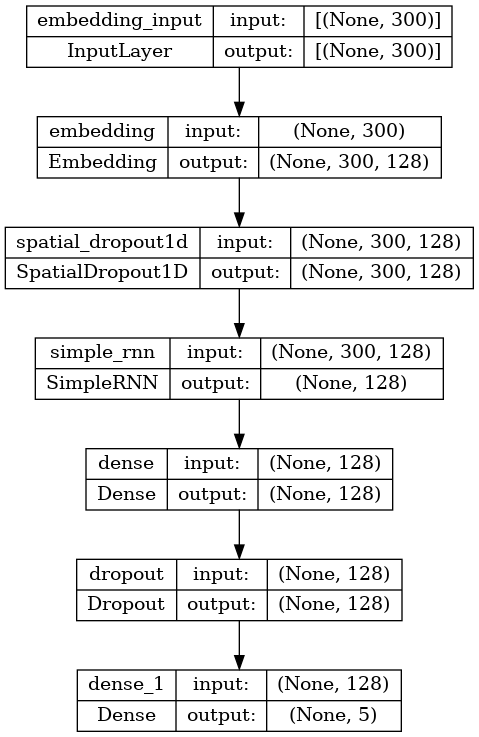

In [ ]:
plot_model(model_simple_rnn, to_file="model.png", show_shapes=True)

In [ ]:
history = model_simple_rnn.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test) ,
    epochs = 10,
    batch_size = 512
)

Epoch 1/10
112/112 [==============================] - 74s 613ms/step - loss: 1.4088 - accuracy: 0.3145 - val_loss: 1.3198 - val_accuracy: 0.3471
Epoch 2/10
112/112 [==============================] - 62s 555ms/step - loss: 1.1686 - accuracy: 0.5034 - val_loss: 1.0042 - val_accuracy: 0.5917
Epoch 3/10
112/112 [==============================] - 61s 546ms/step - loss: 0.9649 - accuracy: 0.6107 - val_loss: 0.8982 - val_accuracy: 0.6494
Epoch 4/10
112/112 [==============================] - 60s 536ms/step - loss: 0.8240 - accuracy: 0.6771 - val_loss: 0.7893 - val_accuracy: 0.6931
Epoch 5/10
112/112 [==============================] - 58s 514ms/step - loss: 0.7091 - accuracy: 0.7291 - val_loss: 0.7118 - val_accuracy: 0.7286
Epoch 6/10
112/112 [==============================] - 57s 508ms/step - loss: 0.6312 - accuracy: 0.7587 - val_loss: 0.6490 - val_accuracy: 0.7545
Epoch 7/10
112/112 [==============================] - 57s 511ms/step - loss: 0.5666 - accuracy: 0.7855 - val_loss: 0.6315 - val_ac

In [ ]:
model_simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 128)         0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

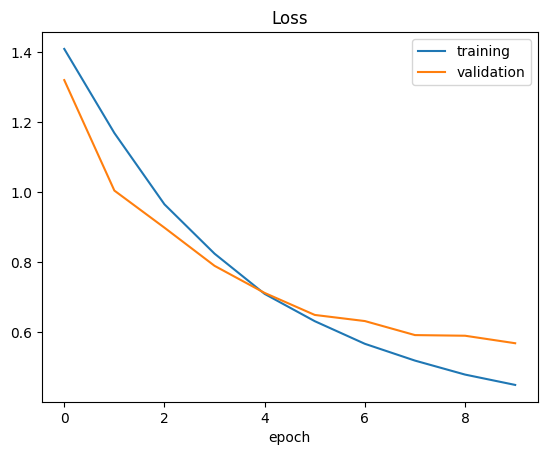

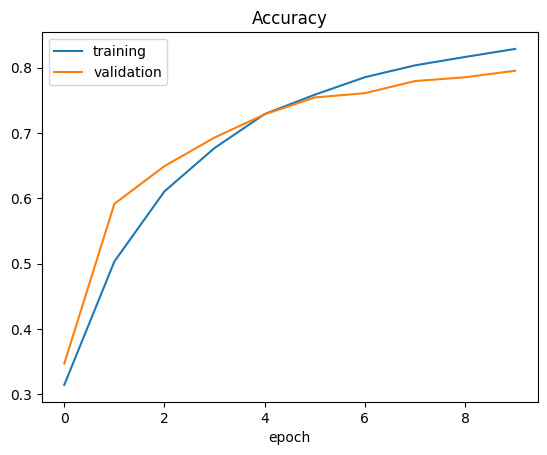

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

## Check the resulting model on the validation data

Prepare valid data for the model

* List item

* List item
* List item


* List item

In [ ]:
df_val = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',
                 usecols=[0,1,2,3], names=['Tweet_ID','entity', 'sentiment', 'tweet_content'])
df_val = df_val.head(1000)

df_val = df_val[['Tweet_ID', 'entity', 'tweet_content', 'sentiment']]

reviews_tweet = df_val['tweet_content'].apply(lambda p: clean_text(p))
reviews_tweet = tokenizer.texts_to_sequences(reviews_tweet)
reviews_tweet = pad_sequences(reviews_tweet, maxlen = 300)
X_samples_val = reviews_tweet
y_samples_val = np.array(label_tokenizer.texts_to_sequences(df_val['sentiment']))


Classification Report for test data

In [ ]:
predictions_test = model_simple_rnn.predict(X_test)
print('Classification Report Test',classification_report(y_test, predictions_test.argmax(axis=1)))

448/448 [==============================] - 10s 22ms/step
Classification Report Test               precision    recall  f1-score   support

           1       0.75      0.89      0.81      4290
           2       0.84      0.76      0.80      3981
           3       0.82      0.78      0.80      3597
           4       0.80      0.71      0.75      2464

    accuracy                           0.80     14332
   macro avg       0.80      0.79      0.79     14332
weighted avg       0.80      0.80      0.79     14332



Classification Report for training data

In [ ]:
predictions_train = model_simple_rnn.predict(X_train)

print('Classification Report Test',classification_report(y_train, predictions_train.argmax(axis=1)))

1792/1792 [==============================] - 42s 23ms/step
Classification Report Test               precision    recall  f1-score   support

           1       0.83      0.96      0.89     17408
           2       0.91      0.85      0.88     15732
           3       0.92      0.87      0.89     14111
           4       0.92      0.83      0.87     10073

    accuracy                           0.89     57324
   macro avg       0.89      0.88      0.88     57324
weighted avg       0.89      0.89      0.89     57324



Classification Report for valid data
1.   List item
2.   List item



In [ ]:
predictions_val = model_simple_rnn.predict(X_samples_val)

print('Classification Report Test',classification_report(y_samples_val, predictions_val.argmax(axis=1)))

32/32 [==============================] - 1s 23ms/step
Classification Report Test               precision    recall  f1-score   support

           1       0.64      0.61      0.62       266
           2       0.83      0.32      0.47       277
           3       0.47      0.82      0.60       285
           4       0.56      0.47      0.51       172

    accuracy                           0.57      1000
   macro avg       0.63      0.56      0.55      1000
weighted avg       0.63      0.57      0.55      1000



# LSTM

# Used libraries
**Pandas** - Pandas is an open source Python library used for data processing and analysis. It provides tools to read and write data in various formats (eg CSV, Excel, SQL databases), clean and transform data, and perform statistical and time series analysis.

**Matplotlib** is a Python library for creating static, animated and interactive visualizations in Python. It provides a wide range of tools for creating high-quality graphs, charts and other data visualizations with support for various types of 2D and 3D plots.

**Beautiful Soup** is a Python library used for web scraping, which is the process of extracting data from websites. It provides tools for parsing HTML and XML documents and extracting useful information from them.

**SpaCy** is a popular open source software library for advanced natural language processing (NLP) in Python. It is designed to be efficient and scalable, with a focus on ease of use and developer productivity. spaCy offers a wide range of text processing features, including tokenization, part-of-speech tagging, named entity recognition, dependency analysis, and more.

**Re-re** (short for regular expression) is a Python module used to work with regular expressions, which are patterns used to match and manipulate text. Regular expressions can be used to find, replace, and extract information from lines of text.

**TensorFlow** is an open source machine learning framework developed by Google that is used to build and train machine learning models. It is designed to make it easy for developers to create and deploy machine learning models for various applications.

In [ ]:
data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',header=None)
data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Working with data

Here we check the data and process it according to our requirements (removing unnecessary columns, removing null rows, etc.).

In [ ]:
data.isna().sum()

0      0
1      0
2      0
3    686
dtype: int64

In [ ]:
data.dropna(inplace=True)
data.shape

(73996, 4)

In [ ]:
# Finding the number of values of each answer in column 2
data[2].value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: 2, dtype: int64

In [ ]:
# Remove irrelevant reviews as they won't help you find sentiment
data_2 = data[data[2]!='Irrelevant']
data_2.shape

(61121, 4)

In [ ]:

# Drop columns 0 and 1 for now, as they won't help you find the key
data_2.drop(columns=[0,1],inplace=True)
data_2.head()

,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
# Dsdjlbv new data values to test the offer definition
data_2.iloc[1000,1]

'Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM'

# Data cleaning

We will now clean up the tweets by removing all unwanted URLs, hashtags, mentions, emoticons, and numbers. We also lemmatize words (reducing all words to root words) and remove unnecessary words that will not change the meaning of the sentence when removed (stop words).

In [ ]:
# creating a lemmatizer object
nlp = spacy.load('en_core_web_sm')

# convert stop words to set for faster processing
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.difference_update({'not', 'no'})
new_stopwords = set(stopwords.copy())

# function to clear data
def cleaned_review(review):
    clean_1_review = BeautifulSoup(review, features="html.parser").get_text()

    # convert to lowercase
    clean_2_review = clean_1_review.lower()

    # remove URL's
    clean_3_review_1 = re.sub(r'http\S+', '', clean_2_review)
    clean_3_review = re.sub(r'www\S+', '', clean_3_review_1)

    # remove everything that is not a letter
    clean_4_review = re.sub('[^a-zA-Z]', ' ', clean_3_review)
    clean_4_review = ' '.join(clean_4_review.split())

    # word tokenization
    clean_5_review = nlp(clean_4_review)

    # remove stop words and lemmatize them
    clean_6_review = [word.lemma_ for word in clean_5_review if word not in new_stopwords]

    # concatenate words into one line
    clean_7_review = ' '.join(clean_6_review)

    # return final data

    return clean_7_review

In [ ]:
# now we will use our function to get the cleaned data
data_2['msg'] = data_2[3].apply(lambda x:cleaned_review(x))

In [ ]:
# compare our cleaned data with the original
print(data_2.iloc[1000,1])
print(data_2.iloc[1000,2])

Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM
eli whitney roth international be make a movie base loosely on use the game bit ly on wv khm


# Fix the length of the tweet

Below is a graph showing that most tweets are 10-20 words after cleaning, and most tweets are under 40 words, so we will fix the number of words per tweet at 40, this will help in augmenting and tokenizing the tweet. besides, it will also help to fix the length of the input in the inline layer which is used for training.

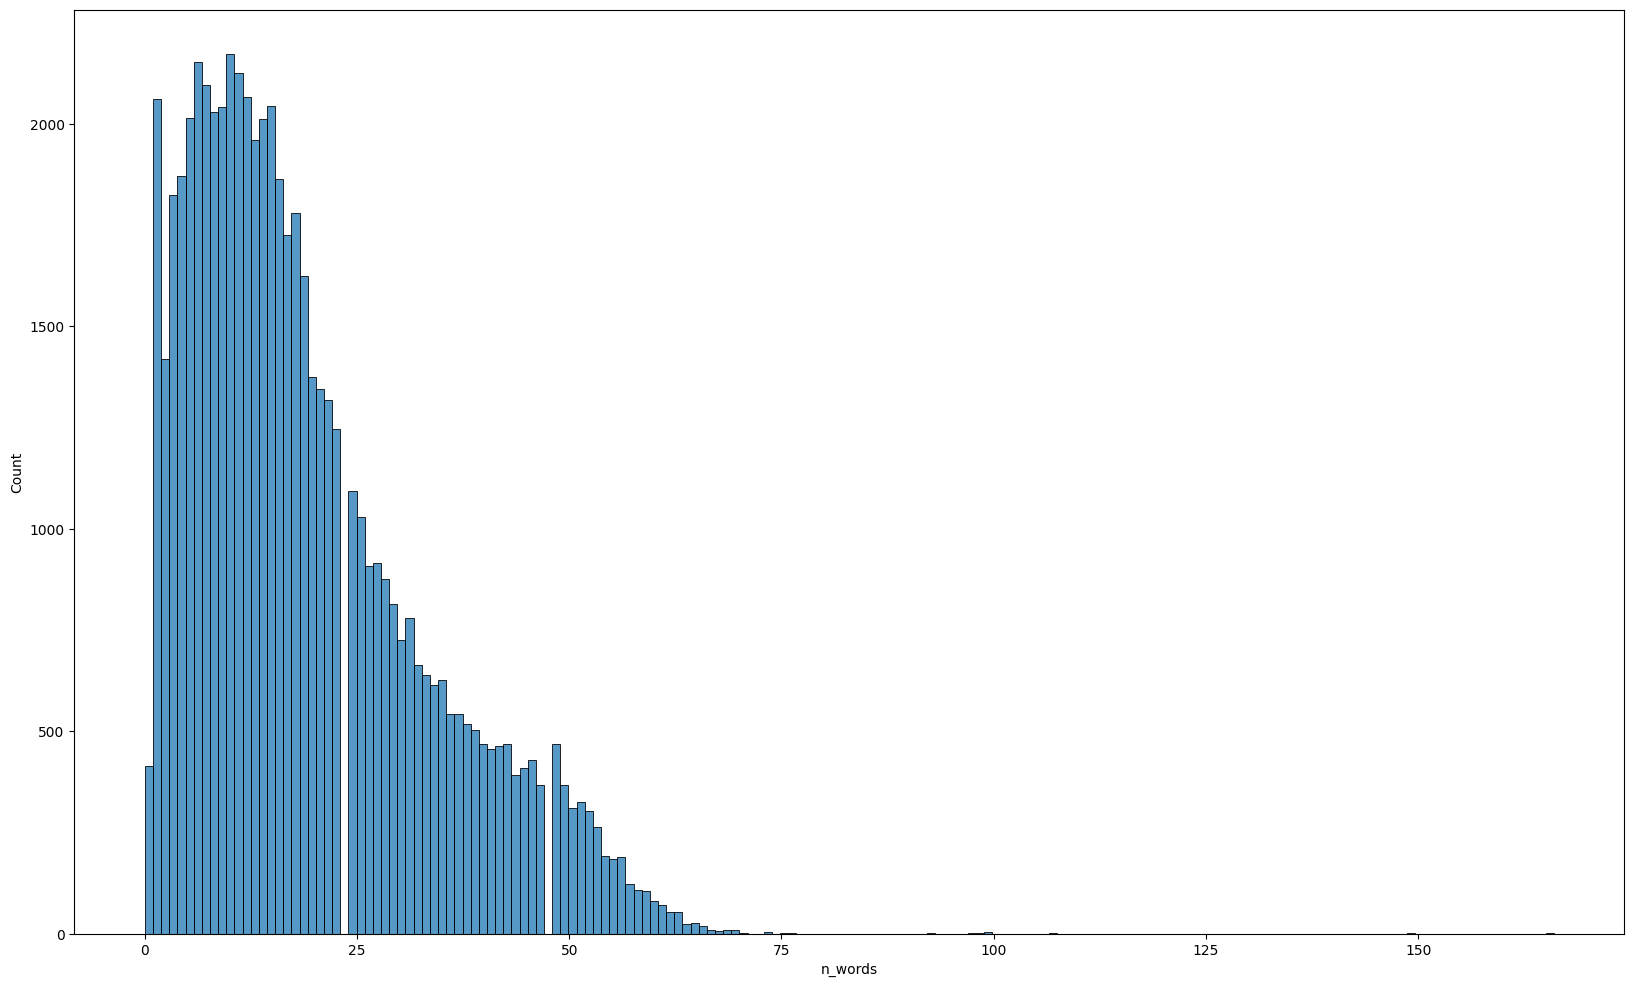

In [ ]:
# fix chart size
fig, ax = plt.subplots(figsize=(20, 12))

# Finding the perfect length
data_2['n_words'] = data_2['msg'].apply(lambda x:len(x.split()))
sns.histplot(data = data_2, x='n_words')
plt.show()

In [ ]:
# So we see above that the maximum number of words in each sentence is 40.
max_len = 50

In [ ]:
# Now we need to tokenize the reviews
sentiment = pd.get_dummies(data_2[2])
data_3 = pd.concat([data_2,sentiment],axis=1)
data_3.head()

,2,3,msg,n_words,Negative,Neutral,Positive
0,Positive,im getting on borderlands and i will murder yo...,I m get on borderland and I will murder you all,11,0,0,1
1,Positive,I am coming to the borders and I will kill you...,I be come to the border and I will kill you all,12,0,0,1
2,Positive,im getting on borderlands and i will kill you ...,I m get on borderland and I will kill you all,11,0,0,1
3,Positive,im coming on borderlands and i will murder you...,I m come on borderland and I will murder you all,11,0,0,1
4,Positive,im getting on borderlands 2 and i will murder ...,I m get on borderland and I will murder you I all,12,0,0,1


In [ ]:
# Removing unnecessary columns
data_3.drop(columns=[2,3,'n_words'],inplace=True)

# Tokenization and padding

Now we will tokenize the words, which means we will convert the words to numbers, because the machine learning models do not understand string values, and we will pad the received tokenized words to bring all tokenized words to the same length of 40 words.

In [ ]:
# now we tokenize the words into a sequence so our model can understand
# we will also pad sentences with less than 40 words to make each sentence equal to
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(data_3['msg'].values)
sequences = tokenizer.texts_to_sequences(data_3['msg'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=max_len, padding='post')

Found 21754 unique tokens.


In [ ]:
# for the target, take: positive, negative and neutral columns from data_3
y=data_3[['Negative','Neutral','Positive']]
y.shape

(61121, 3)

# Data separation

Now we have cleaned the data, it's time to separate the data into training and testing, training data will help in training the data, and testing will help to check how well our model is able to work with new data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.shape,X_test.shape

((60509, 50), (612, 50))

# Model creation


We use the keras library from tensorflow to build our model. here are the following modules used in creating the model

**Sequential** - "tensorflow.keras.models.Sequential" is a class in the TensorFlow Keras API that allows users to build a neural network model by stacking layers sequentially. This means that the output of one layer is fed as input to the next layer.

**Embedding** - "tensorflow.keras.layers.Embedding" is a layer in the TensorFlow Keras API that is used to create word embeddings for natural language processing tasks. The Embedding layer maps an input sequence of integers to a sequence of dense vectors, where each integer represents the index of a word in the dictionary.

**SpatialDropout1D** - "tensorflow.keras.layers.SpatialDropout1D" is a layer in the TensorFlow Keras API that applies a dropout regularization type to 1D Convolutional Neural Network (CNN) input for sequence data such as text or time series data. Dropout is a technique used to prevent overfitting in neural networks by randomly excluding (zeroing) some neurons in a layer during training.

**LSTM** - LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) layer in TensorFlow that is typically used to process sequential data such as text or time series. LSTM is designed to overcome the limitations of traditional RNNs, which have difficulty with long-term dependencies and are prone to the vanishing gradient problem.

**Dense** - "Dense" is a layer type in TensorFlow that is used in neural networks to map an input tensor to an output tensor by performing a matrix multiplication and an activation function on the input. A dense layer is a fully connected layer, meaning every neuron in a layer is connected to every neuron in the previous layer.

**ModelCheckpoint** - "ModelCheckpoint" is a callback function in TensorFlow that allows you to save a model at specific intervals during training. This is useful for long training runs where you may want to periodically save your model to avoid losing progress if you abort.

**EarlyStopping** - "EarlyStopping" is a callback function in TensorFlow that allows you to stop model training early based on a specified metric. This can be useful when training a model for a long time, as it allows us to stop training when the performance on the validation set no longer improves, thus saving time and computational resources.

In [ ]:
# n_most_words = 23091(vocab_size)+1
n_most_words = len(word_index) + 1
n_dim = 50

# create a model
model = Sequential()
model.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(100,dropout=0.25,recurrent_dropout=0.25))
model.add(Dense(50,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1087750   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 3)                 78        
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(patience=5)
model_history = model.fit(X_train,y_train,epochs=15,validation_split = 0.1, batch_size = 128 ,callbacks=[checkpoint,early_stop])

Epoch 1/15
426/426 [==============================] - 138s 314ms/step - loss: 0.9161 - acc: 0.5216 - val_loss: 0.7596 - val_acc: 0.6125
Epoch 2/15
426/426 [==============================] - 106s 248ms/step - loss: 0.7029 - acc: 0.6545 - val_loss: 0.6709 - val_acc: 0.7106
Epoch 3/15
426/426 [==============================] - 104s 245ms/step - loss: 0.5138 - acc: 0.7919 - val_loss: 0.4660 - val_acc: 0.8194
Epoch 4/15
426/426 [==============================] - 102s 239ms/step - loss: 0.3738 - acc: 0.8571 - val_loss: 0.3926 - val_acc: 0.8493
Epoch 5/15
426/426 [==============================] - 102s 239ms/step - loss: 0.3120 - acc: 0.8805 - val_loss: 0.3617 - val_acc: 0.8693
Epoch 6/15
426/426 [==============================] - 101s 237ms/step - loss: 0.2786 - acc: 0.8945 - val_loss: 0.3718 - val_acc: 0.8668
Epoch 7/15
426/426 [==============================] - 102s 239ms/step - loss: 0.2594 - acc: 0.8993 - val_loss: 0.3788 - val_acc: 0.8665
Epoch 8/15
426/426 [============================

# Model performance check and visualization

Now our model is trained, let's check how it performs on our test data and visualize it as a graph based on each epoch.

In [ ]:
# Check for loss and accuracy
model.load_weights('weights.hdf5')
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20/20 [==============================] - 0s 15ms/step - loss: 0.2822 - acc: 0.8987
Test set
  Loss: 0.282
  Accuracy: 0.899


In [ ]:
# renderer result
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

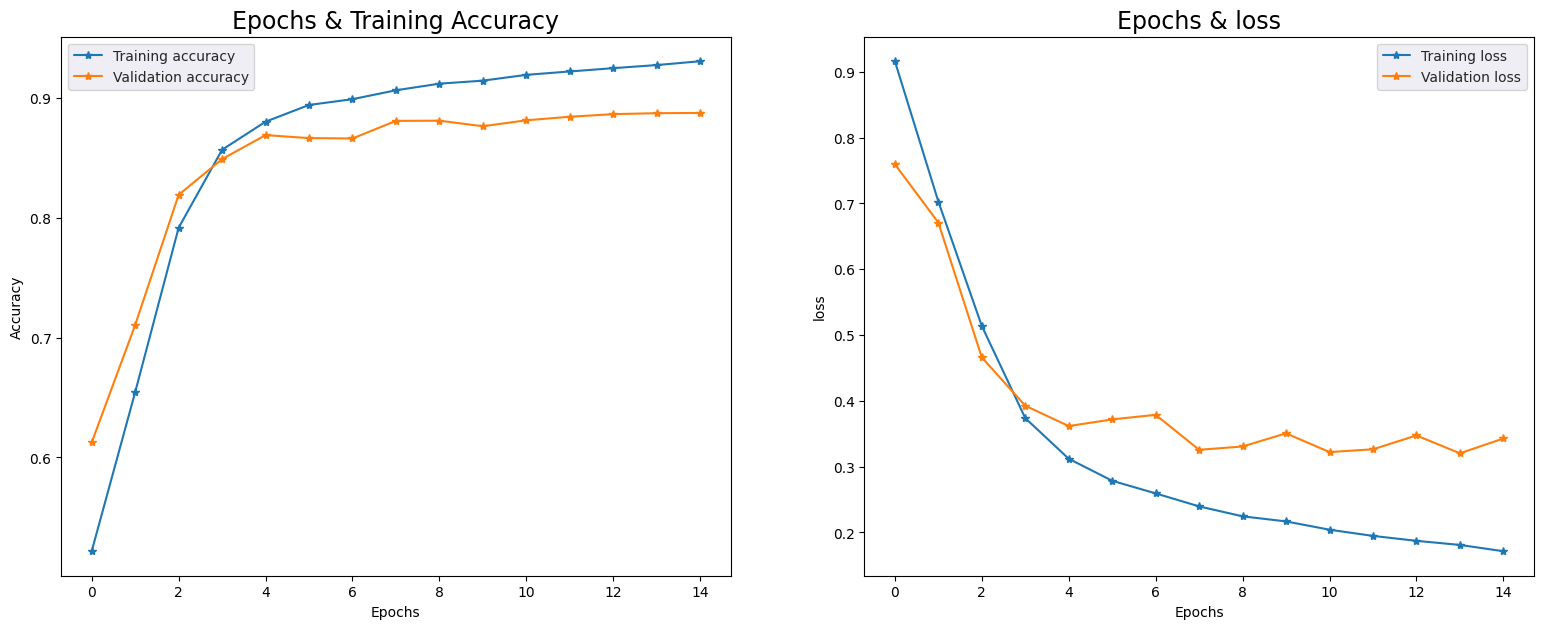

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

# Using our model for a real problem

Now we have tested our model and are satisfied with the results, let's use it and see how it performs in real life problems. We also created a function that takes a tweet as input and returns the mood of the tweet.

In [ ]:
# function for prediction
def find_sentiment(review):
    review = cleaned_review(str(review))
    seq = tokenizer.texts_to_sequences([review])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = ['Negative','Neutral','Positive']
    return label[np.argmax(pred)]

In [ ]:
# check with training data
data.iloc[1000]

0                                                 2578
1                                          Borderlands
2                                             Negative
3    @ EpicGames @ 2K @ Steam Why add a crossplay f...
Name: 1004, dtype: object

In [ ]:
# check if our function produces the expected result
print(find_sentiment(["@ EpicGames @ 2K @ Steam Why add a crossplay for @ Borderlands 3 if you're not going to make it compatible for the console?"]))

1/1 [==============================] - 0s 265ms/step
Negative


In [ ]:
# Now read the data frame that has tweets not trained on the model
v_data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',header=None)
v_data.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
# Remove irrelevant data from column 2 since we didn't use it for prediction
v_data = v_data[v_data[2]!='Irrelevant']

In [ ]:
# Finding the final prediction in the validation set, the last column "prediction" is where the output of our models is stored.
v_data['predicted'] = v_data[3].apply(lambda x:find_sentiment([x]))
v_data.head(10)

1/1 [==============================] - 0s 31ms/step


,0,1,2,3,predicted
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,Positive
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",Positive
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,Positive
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...,Negative
10,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...,Positive
